In [1]:
import json
import re
import sentencepiece as spm
from tqdm import tqdm
import tiktoken
import matplotlib.pyplot as plt

### Cleaning Raw Text
This notebook begins by processing the raw json that was produced by the `generate_training_data` script. If you're starting from the already cleaned text I uploaded to Hugging Face, you can skip to the next section and load e.g. `train.txt` instead of `cleaned_text.txt`, 

In [2]:
data = []
for epoch in range(123):
    with open(f"training_data/raw_training_data_{epoch}.json") as f:
        data.extend(json.load(f))

In [174]:
len(data)

107471

In [195]:
cleaned_text = []

for batch in tqdm(data):

    samples = batch.split('\nNote: ')[0]

    replacements = [
        (r'</hassistant', '</h1>MALFORMED'),
        (r'<p/', ''),
        (r'<p', ''),
        (r'/p', ''),
        (r'</1>', '<h1>'),
        (r'h1/', 'h1>'),
        (r' h1 ', ''),
        (r'/h1', 'h1'),
        (r'\n', ''),
        (r'<', ''),
        (r'>', ''),
        (r'=', ''),
        (r'\\', ''),
        (r'`', ''),
        (r';', ''),
        (r'\+', ''),
        (r'_', ' '),
    ]

    for pattern, repl in replacements:
        samples = re.sub(pattern, repl, samples)

    samples = samples.lower()

    samples = samples.split('h1')

    samples = [s.strip() for s in samples if s]

    # Check for title/article count
    if len(samples) not in (18, 20, 22, 24, 38, 40):
        continue

    bad_samples = []
    
    for i in range(0, len(samples) - 1, 2):

        pattern = r'[\[\]\(\)\/\@\#\^]|\.{3}'

        conditions = [
            re.search(pattern, samples[i]),
            re.search(pattern, samples[i+1]),
            re.search(r'headline', samples[i]),
            len(samples[i]) < 16,
            len(samples[i]) > 80,
            len(samples[i+1]) < 150,
        ]

        if any(conditions):
            bad_samples.extend([i, i+1])
            continue
        
        samples[i] = re.sub(r'^[^a-z0-9]', '', samples[i])
        samples[i+1] = re.sub(r'^[^a-z0-9]', '', samples[i+1])

        if samples[i+1].count('.') < 2:
            bad_samples.extend([i, i+1])
            continue

    cleaned_samples = []

    for i, s in enumerate(samples):
        if i not in bad_samples:
            cleaned_samples.append(s)

    cleaned_text.extend(cleaned_samples)

100%|██████████| 107471/107471 [00:16<00:00, 6358.32it/s]


In [196]:
len(cleaned_text)/2

1081379.0

In [197]:
cleaned_text[:2]

['standardized testing to become mandatory for all students',
 "the government has announced that standardized testing will become mandatory for all students. the tests are designed to measure a student's knowledge and skills in various subjects. the government says the tests will help identify areas where students need improvement and will allow schools to provide targeted support. many students and teachers are concerned about the stress and pressure the tests will bring. the tests are expected to start next year."]

In [202]:
with open('training_data/cleaned_text.txt', 'w') as f:
    for i in range(0, len(cleaned_text) - 1, 2):
        f.write(f'{cleaned_text[i]} </h> {cleaned_text[i+1]}\n')

In [3]:
cleaned_text = []
with open('training_data/cleaned_text.txt', 'r') as f:
    for line in f:
        cleaned_text.append(line.strip())

### Training the Tokenizers

In [ ]:
user_defined_symbols = ["</h>", "%", ":", '"', "!", "$", "?", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

for tok_size in [1024, 2048, 4096, 8192, 16384]:
    spm.SentencePieceTrainer.train(
        input='training_data/cleaned_text.txt',
        model_prefix=f'tokenizers/tinynewstokenizer{tok_size}',
        vocab_size=tok_size,
        model_type='bpe',
        user_defined_symbols=user_defined_symbols
    )

In [4]:
for tok_size in [1024, 2048, 4096, 8192, 16384]:
    sp = spm.SentencePieceProcessor(model_file=f'tokenizers/tinynewstokenizer{tok_size}.model')
    print(sp.encode(cleaned_text[0], out_type=str))

['▁st', 'and', 'ard', 'ized', '▁test', 'ing', '▁to', '▁become', '▁m', 'and', 'at', 'ory', '▁for', '▁all', '▁students', '▁', '</h>', '▁the', '▁government', '▁has', '▁an', 'no', 'un', 'ced', '▁that', '▁st', 'and', 'ard', 'ized', '▁test', 'ing', '▁will', '▁become', '▁m', 'and', 'at', 'ory', '▁for', '▁all', '▁students', '.', '▁the', '▁t', 'es', 'ts', '▁are', '▁designed', '▁to', '▁me', 'as', 'ure', '▁a', '▁student', "'", 's', '▁k', 'n', 'ow', 'l', 'ed', 'ge', '▁and', '▁sk', 'ills', '▁in', '▁var', 'ious', '▁su', 'b', 'ject', 's', '.', '▁the', '▁government', '▁s', 'ays', '▁the', '▁t', 'es', 'ts', '▁will', '▁help', '▁', 'ident', 'if', 'y', '▁are', 'as', '▁whe', 're', '▁students', '▁need', '▁improve', 'ment', '▁and', '▁will', '▁allow', '▁school', 's', '▁to', '▁provide', '▁t', 'ar', 'get', 'ed', '▁support', '.', '▁many', '▁students', '▁and', '▁teac', 'hers', '▁are', '▁concern', 'ed', '▁about', '▁the', '▁st', 'ress', '▁and', '▁p', 'ress', 'ure', '▁the', '▁t', 'es', 'ts', '▁will', '▁bring', '.', '

In [6]:
for tok_size in (1024, 2048, 4096, 8192, 16384):
    sp = spm.SentencePieceProcessor(model_file=f'tokenizers/tinynewstokenizer{tok_size}.model')
    print(f'{tok_size}: {sum([len(sp.encode(s, out_type=int)) for s in cleaned_text[:100_000]])/100_000:.1f}')

1024: 126.4
2048: 105.4
4096: 91.7
8192: 84.8
16384: 84.8


In [7]:
for model in ('gpt2', 'gpt-4', 'gpt-4o'):
    encoding = tiktoken.encoding_for_model(model)
    token_count = sum([len(encoding.encode(s)) for s in cleaned_text[:100_000]])/100_000
    print(f'{model} | {encoding.n_vocab} | {token_count:.1f}')

gpt2 | 50257 | 82.3
gpt-4 | 100277 | 82.1
gpt-4o | 200019 | 81.6


| Tokenizer |  Vocab  | Avg # Tokens |
|-----------|---------|--------------|
| TN-10     |   1,024 |    126.4     |
| TN-11     |   2,048 |    105.4     |
| TN-12     |   4,096 |     91.7     |
| TN-13     |   8,192 |     84.8     |
| TN-14     |  16,384 |     84.8     |
| gpt2      |  50,257 |     82.3     |
| gpt-4     | 100,277 |     82.1     |
| gpt-4o    | 200,019 |     81.6     |

In [240]:
tokenizers = {}
token_counts = {}

for tok_size in [1024, 2048, 4096, 8192, 16384]:
    tokenizers[tok_size] = spm.SentencePieceProcessor(model_file=f'tokenizers/tinynewstokenizer{tok_size}.model')
    token_counts[tok_size] = []

with open('training_data/cleaned_text.txt', 'r') as file:
    for line in tqdm(file):
        for tok_size in [1024, 2048, 4096, 8192, 16384]:
            token_counts[tok_size].append(len(tokenizers[tok_size].encode(line, out_type=int)))

1081379it [09:41, 1858.46it/s]


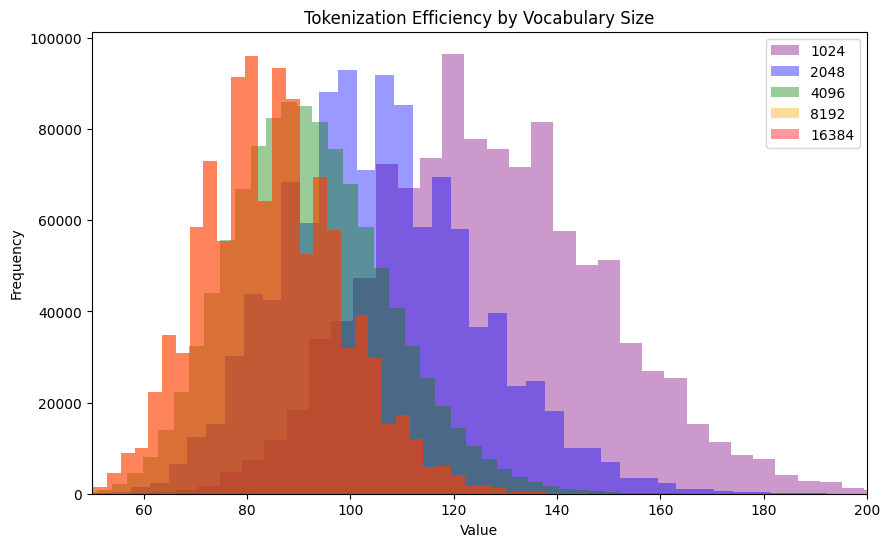

In [268]:
# Colors for each set
colors = ['purple', 'blue', 'green', 'orange', 'red']

# Plotting the histograms
plt.figure(figsize=(10, 6))

for (label, data), color in zip(token_counts.items(), colors):
    plt.hist(data, bins=50, color=color, alpha=0.4, label=label)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Tokenization Efficiency by Vocabulary Size')
plt.xlim(50, 200)
plt.legend()
plt.show()


In [258]:
f'{len([n for n in token_counts[8192] if n <= 128]) / len(token_counts[8192]) * 100:.2f}% of bulletins tokenized with vocab size 8192 have 128 or fewer tokens'

'99.79% of bulletins tokenized with vocab size 8192 have 128 or fewer tokens'